## Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder


Read in player data

In [2]:
playerDf = pd.read_csv('trainingData/CollegeBasketballPlayers2009-2021.csv', low_memory=False)

#initial dropping of inconsistant data for player data 
playerDf = playerDf.rename(columns = {'Unnamed: 64' : 'role_position'})
playerDf = playerDf.drop('Unnamed: 65', axis=1) # Has no meaning in the dataset
playerDf = playerDf.drop('ht', axis=1) # Temporarily excluding this column due to inconsistent date formats and other values
playerDf = playerDf.drop('num', axis=1) # It might denote a player's choice or position but with significant variation in meaning.
playerDf = playerDf.drop('type', axis=1) # Column has 1 unique value
playerDf= playerDf.drop('pid', axis=1) # catigorical, not needed 
playerDf= playerDf.drop('yr', axis=1) # catigorical, not needed 

playerDf.shape

(61061, 60)

Read In team data

In [3]:
#team data
teamDf = pd.read_csv('trainingData/teamData2013-2023.csv', low_memory=False)
teamDf.shape

(3523, 24)

Display columns with over 60% nulls and drop them

In [4]:
# Count and remove columns with over 60% nan values 
total = len(playerDf)
for column in playerDf.columns:
    count = playerDf[column].isna().sum()
    percent= (count/ total) * 100
    if (percent>=60):
        print(f"Player  DF: Column '{column}':", f"Number of NaN: {count}", f"Percentage: {percent:.2f}%")
        
total = len(teamDf)
for col in teamDf.columns:
    count = teamDf[col].isnull().sum()
    percent=count/total * 100
    if(percent>=60):
        print(f"Team  DF: Column '{col}':", f"Number of NaN: {count}", f"Percentage: {percent:.2f}%")

Player  DF: Column 'Rec Rank': Number of NaN: 42591 Percentage: 69.75%
Player  DF: Column 'pick': Number of NaN: 59626 Percentage: 97.65%
Team  DF: Column 'POSTSEASON': Number of NaN: 2843 Percentage: 80.70%
Team  DF: Column 'SEED': Number of NaN: 2843 Percentage: 80.70%


In [5]:
#Drop all the over 60% cols
playerDf = playerDf.drop('pick', axis=1) 
playerDf = playerDf.drop('Rec Rank', axis=1) 

#for team data, there are actually no more nan values in any cells
teamDf= teamDf.drop('POSTSEASON', axis=1)
teamDf= teamDf.drop('SEED', axis=1)

Findand remove redundant data in both player and team df

In [6]:
team_corr_matrix = teamDf.corr()
player_corr_matrix=playerDf.corr()

# find any corrilation >.9 to determine redundant features 
threshold = 0.9  


# Iterate through the correlation matrix and print highly correlated pairs
for i in range(len(player_corr_matrix.columns)):
    for j in range(i + 1, len(player_corr_matrix.columns)):  # Added a closing parenthesis here
        if abs(player_corr_matrix.iloc[i, j]) >= threshold:
            print(f"Player: {player_corr_matrix.columns[i]} and {player_corr_matrix.columns[j]}: {player_corr_matrix.iloc[i, j]:.2f}")



# Iterate through the correlation matrix and print highly correlated pairs
for i in range(len(team_corr_matrix.columns)):
    for j in range(i + 1, len(team_corr_matrix.columns)):
        if abs(team_corr_matrix.iloc[i, j]) > threshold:
            print(f"Team : {team_corr_matrix.columns[i]} and {team_corr_matrix.columns[j]}: {team_corr_matrix.iloc[i, j]:.2f}")

Player: Min_per and stops: 0.95
Player: Min_per and mp: 0.96
Player: Ortg and adjoe: 0.97
Player: eFG and TS_per: 0.93
Player: FTM and FTA: 0.98
Player: twoPM and twoPA: 0.98
Player: twoPM and rimmade: 0.95
Player: twoPM and rimmade+rimmiss: 0.94
Player: twoPA and rimmade: 0.91
Player: twoPA and rimmade+rimmiss: 0.93
Player: twoPA and midmade+midmiss: 0.92
Player: TPM and TPA: 0.99
Player: rimmade and rimmade+rimmiss: 0.98
Player: midmade and midmade+midmiss: 0.98
Player: dunksmade and dunksmiss+dunksmade: 1.00
Player: drtg and adrtg: 0.94
Player: dporpag and stops: 0.90
Player: stops and mp: 0.91
Player: gbpm and ogbpm: 0.94
Player: mp and pts: 0.90
Player: dreb and treb: 0.97
Team : BARTHAG and WAB: 0.93
Team : EFG_D and 2P_D: 0.91


In [7]:
# remove redundancy in player 
playerDf= playerDf.drop('rimmade', axis=1) 
playerDf= playerDf.drop('rimmade+rimmiss', axis=1) 
playerDf= playerDf.drop('Ortg', axis=1) 
playerDf= playerDf.drop('Min_per', axis=1) 
playerDf= playerDf.drop('eFG', axis=1) 
playerDf= playerDf.drop('drtg', axis=1)
playerDf= playerDf.drop('stops', axis=1)
playerDf= playerDf.drop('gbpm', axis=1)
playerDf= playerDf.drop('dreb', axis=1)
playerDf= playerDf.drop('midmade+midmiss', axis=1)
playerDf= playerDf.drop('dunksmiss+dunksmade', axis=1)
playerDf= playerDf.drop('twoPA', axis=1)
playerDf= playerDf.drop('TPA', axis=1)
playerDf= playerDf.drop('FTA', axis=1)

#remove in team
teamDf= teamDf.drop('WAB', axis=1)
teamDf= teamDf.drop('2P_D', axis=1)

Filter out non matching years between data frames and fix col. titles for joining

In [8]:
playerDf=  playerDf[playerDf['year'] > 2013]
playerDf=  playerDf[playerDf['year'] !=2020]

In [9]:
#make all the team cols non caps 
teamDf.columns = map(str.lower, teamDf.columns)

In [10]:
#drop duplicate conference col. between the two and rename simila named cols distinguish between player and team
playerDf= playerDf.drop('conf', axis=1)

simialrCols=set(teamDf.columns) & set(playerDf.columns)
for column in simialrCols:
    if column != "team" and column != "year":
        teamDf = teamDf.rename(columns={column: f"{column}_team"})
        playerDf = playerDf.rename(columns={column: f"{column}_player"})


In [11]:
# join the team stats to players based on the year and team
joinedDf =pd.merge(playerDf,teamDf, on=['team', 'year'])

KNN to fill in all NAN values

In [12]:
team_label_encoder = LabelEncoder()
joinedDf['team'] = team_label_encoder.fit_transform(joinedDf['team'])

conf_label_encoder = LabelEncoder()
joinedDf['conf'] = conf_label_encoder.fit_transform(joinedDf['conf'])

role_position_label_encoder = LabelEncoder()
joinedDf['role_position'] = role_position_label_encoder.fit_transform(joinedDf['role_position'])

player_name_label_encoder = LabelEncoder()
joinedDf['player_name'] = player_name_label_encoder.fit_transform(joinedDf['player_name'])

In [13]:
imputer = KNNImputer(n_neighbors=10)
imputed_numeric = imputer.fit_transform(joinedDf.select_dtypes(include=np.number))
dfBasketballTraining_filled = pd.DataFrame(imputed_numeric, columns=joinedDf.select_dtypes(include=np.number).columns)
string_columns = joinedDf.select_dtypes(include='object').columns
imputed_data = pd.concat([joinedDf[string_columns], dfBasketballTraining_filled], axis=1)

In [15]:
trainDf = pd.DataFrame(imputed_data, columns=joinedDf.columns)

Finding outliers and smoothing the data 

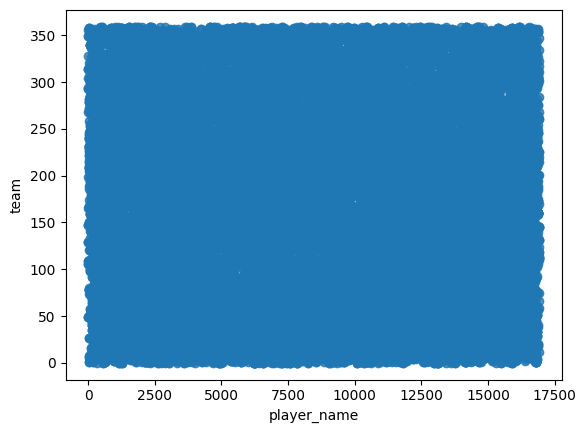

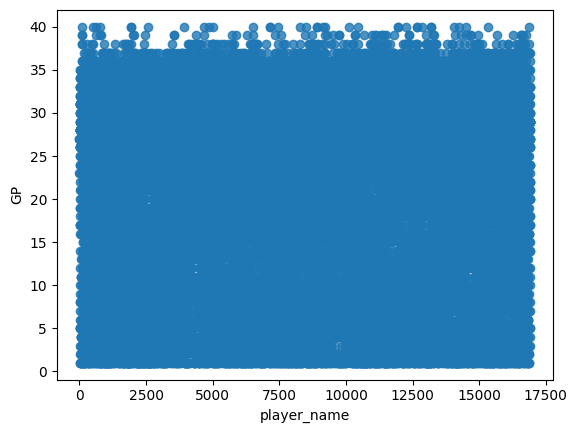

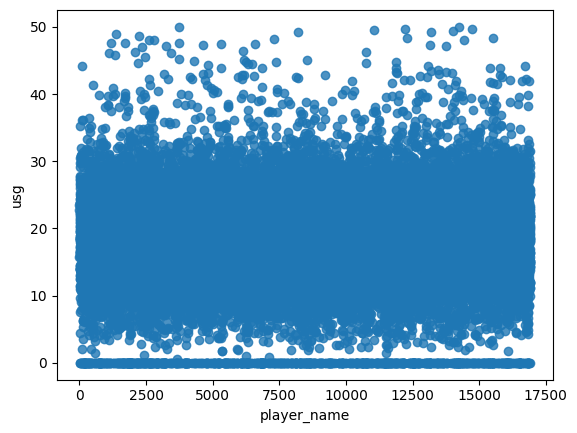

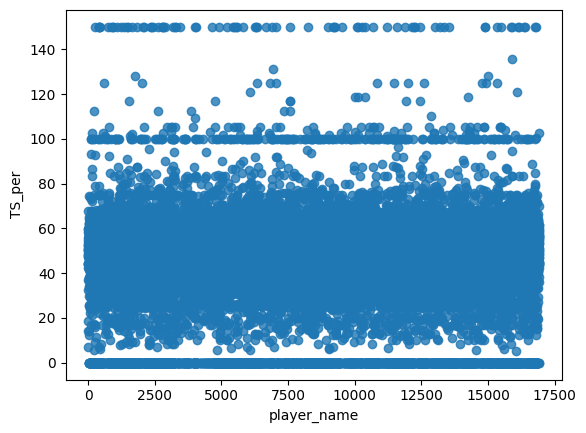

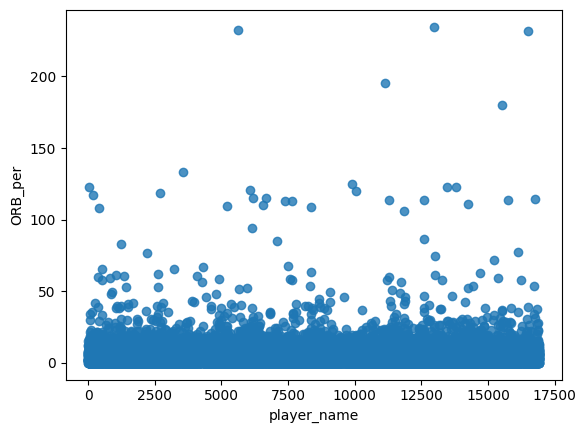

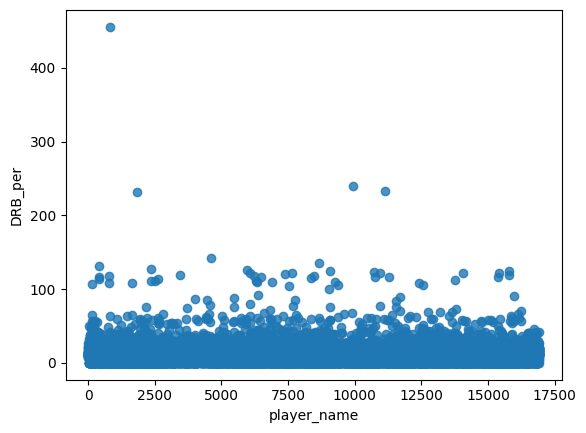

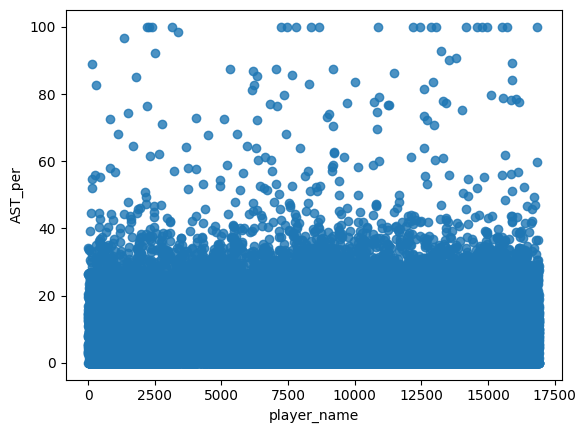

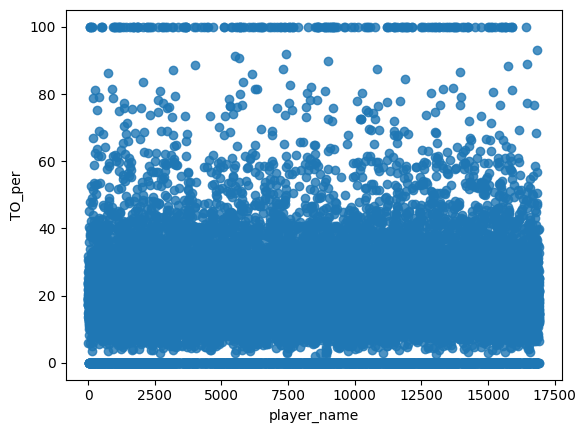

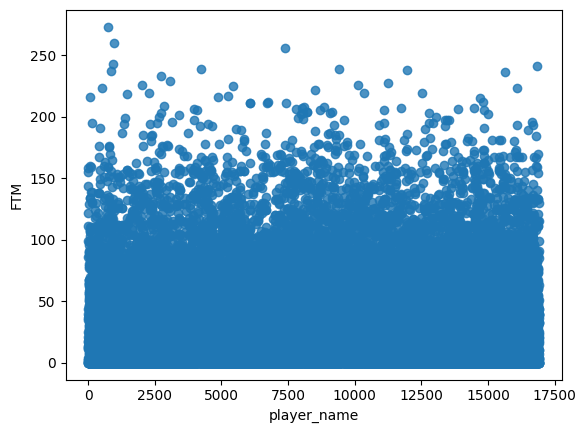

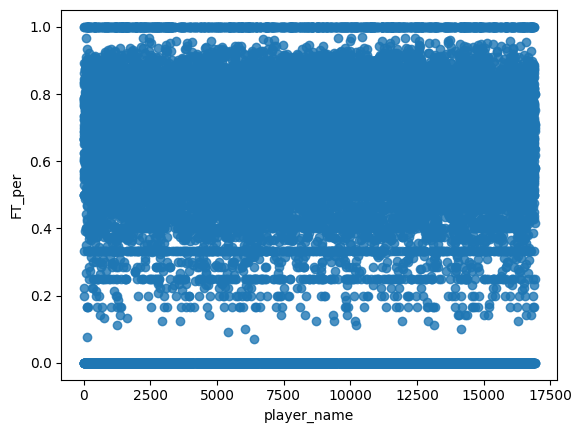

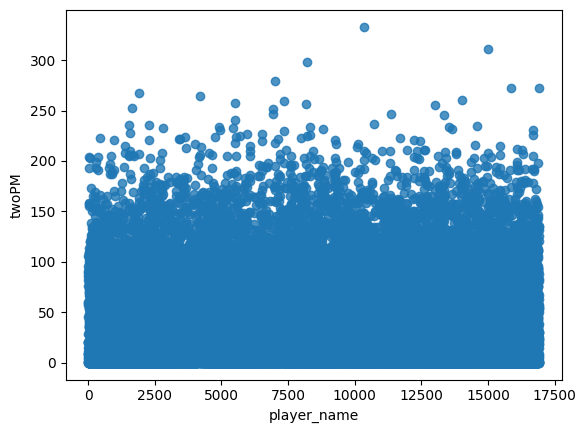

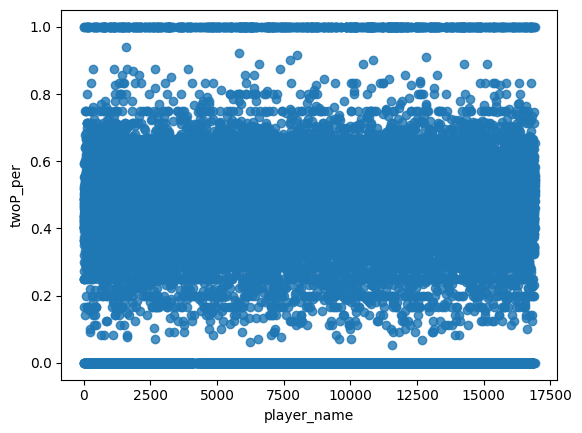

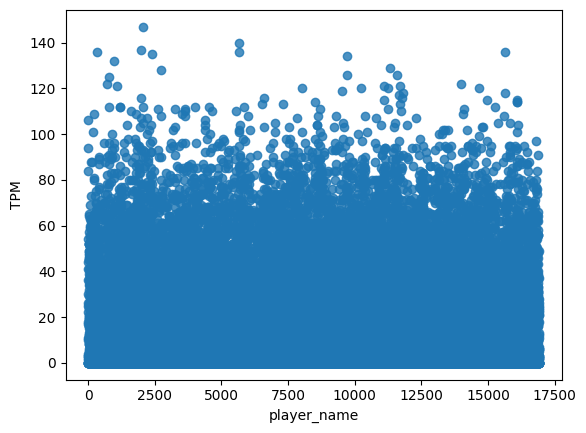

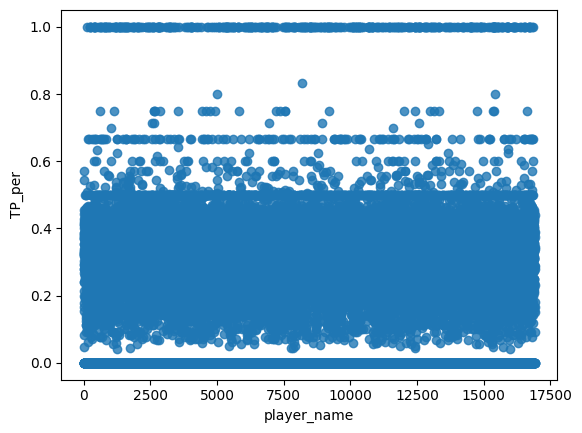

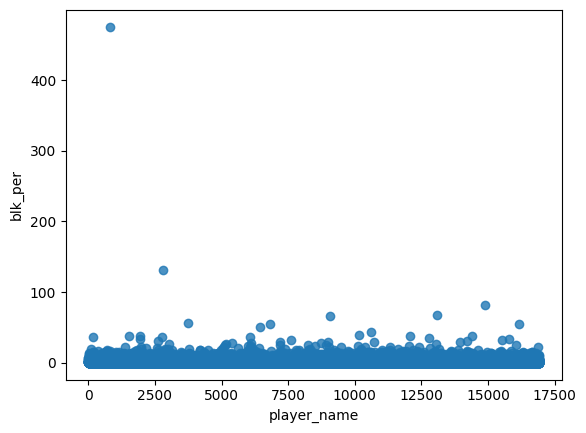

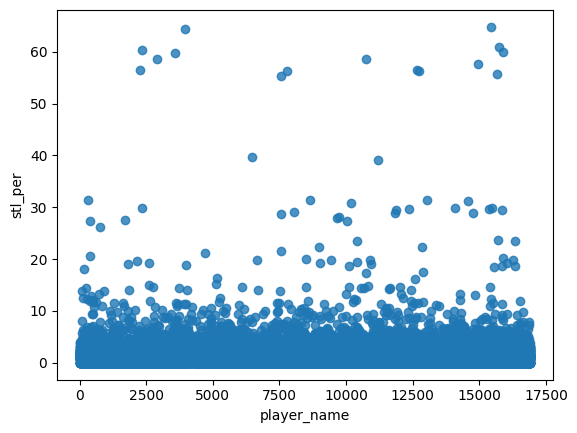

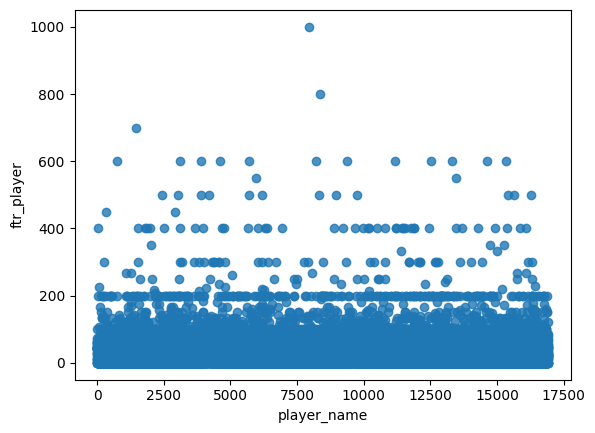

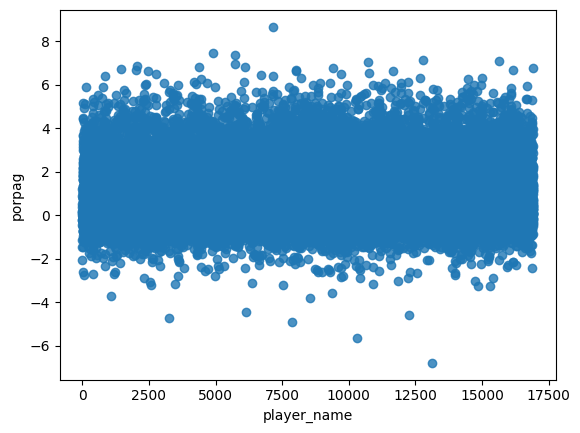

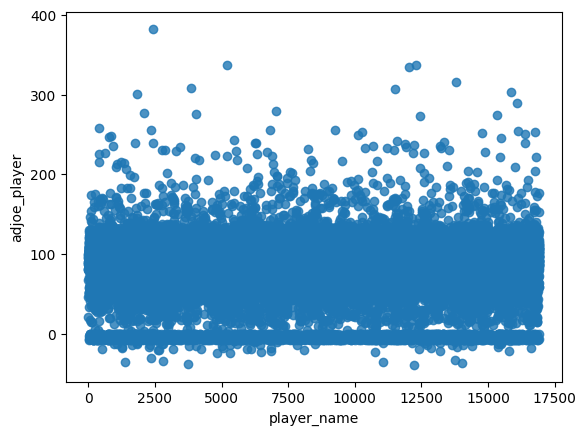

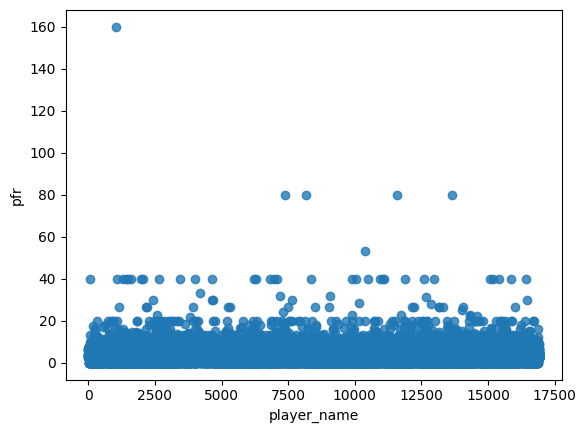

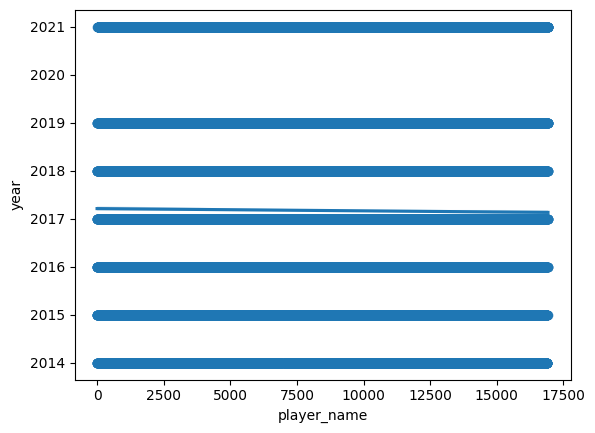

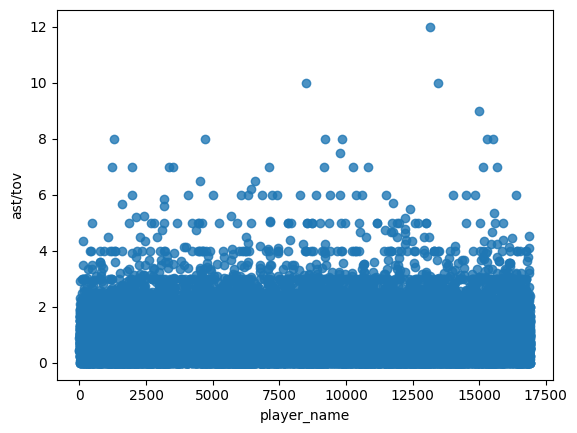

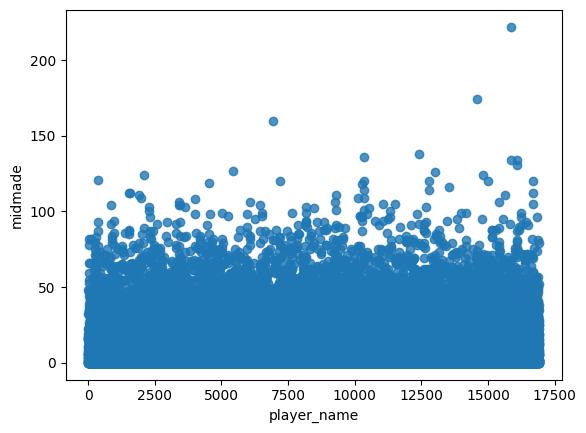

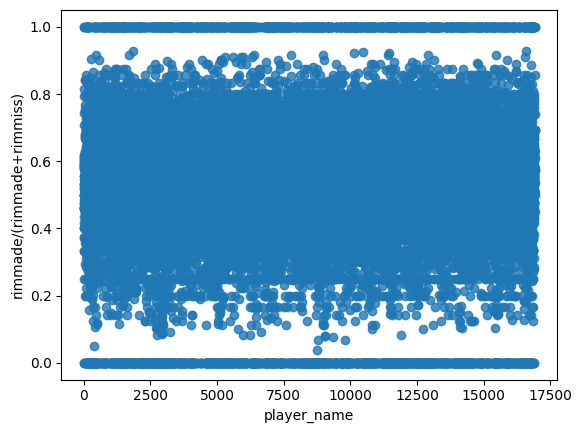

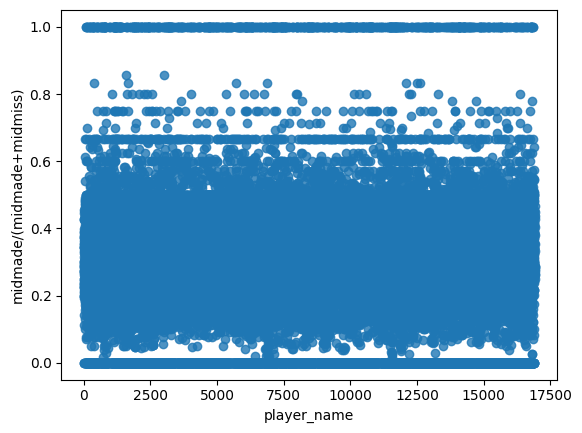

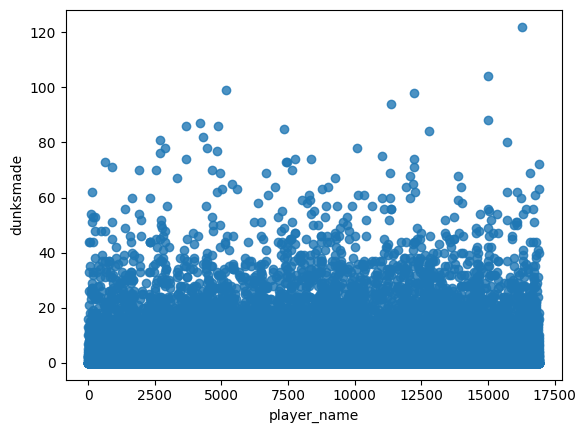

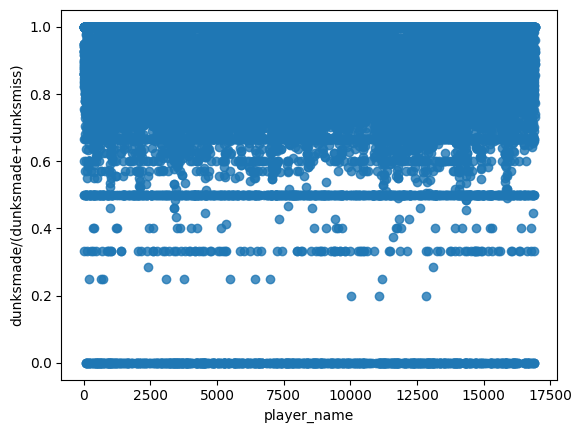

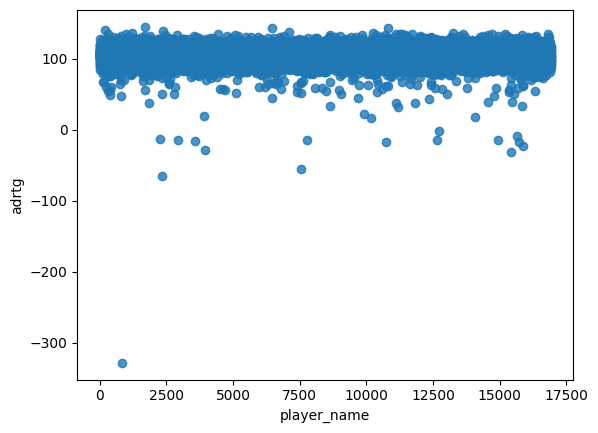

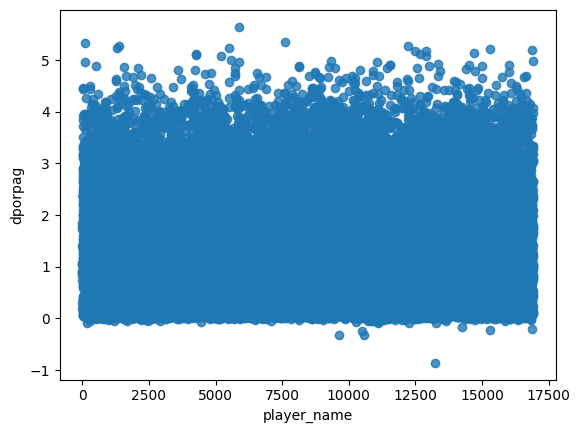

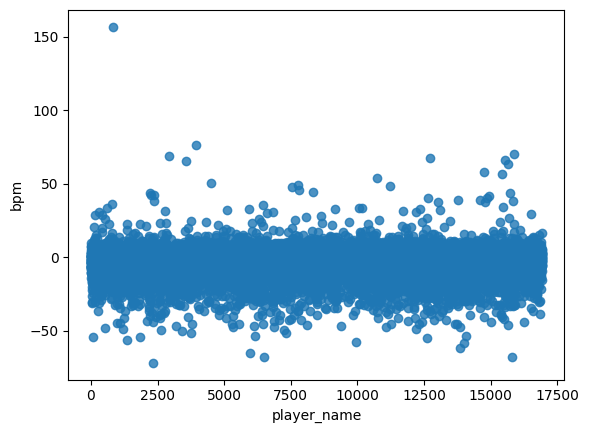

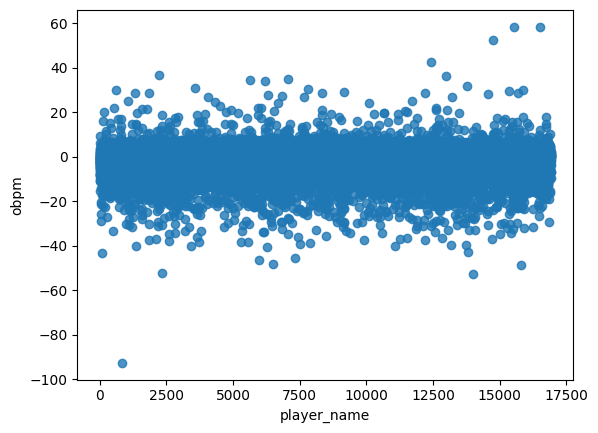

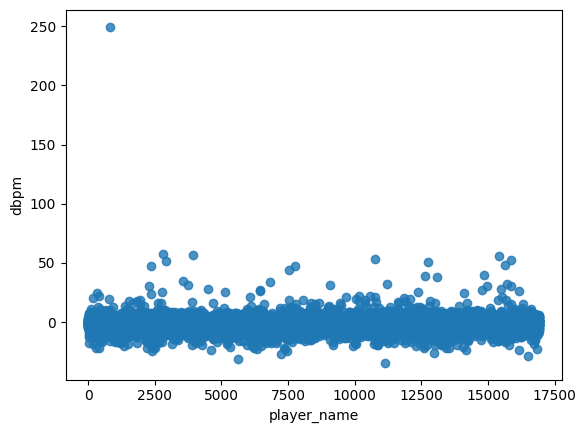

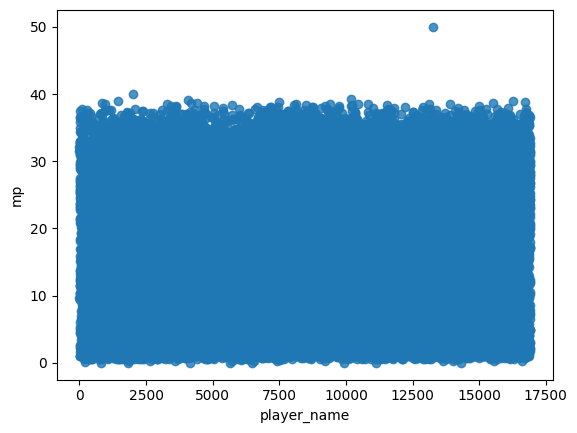

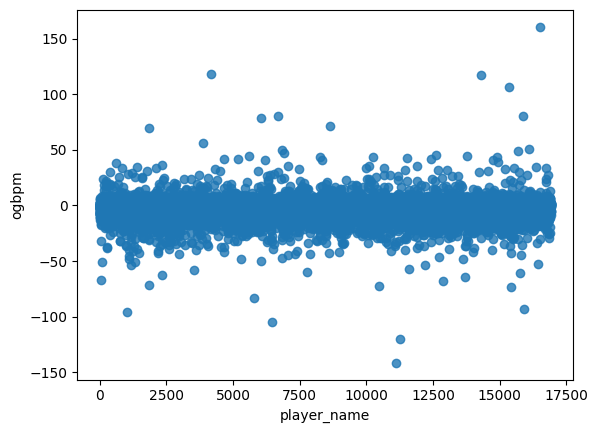

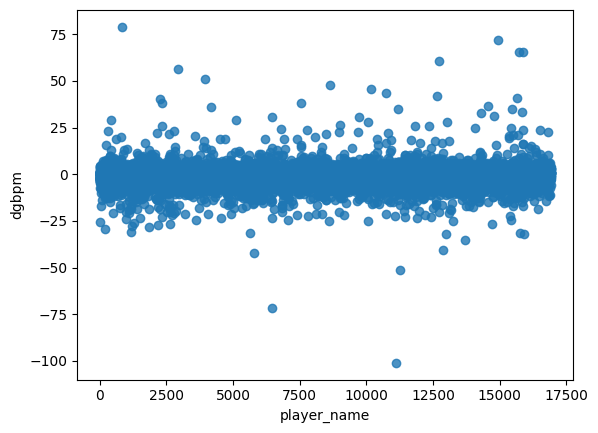

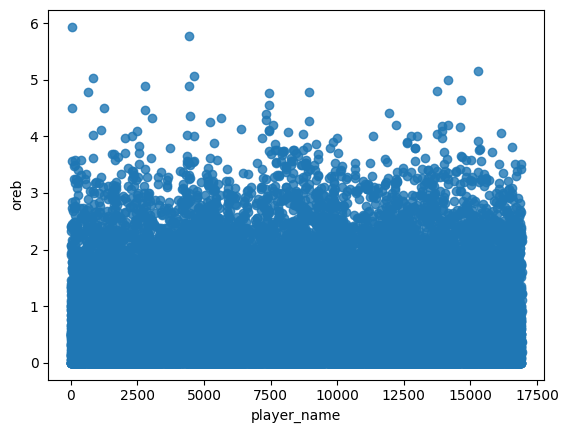

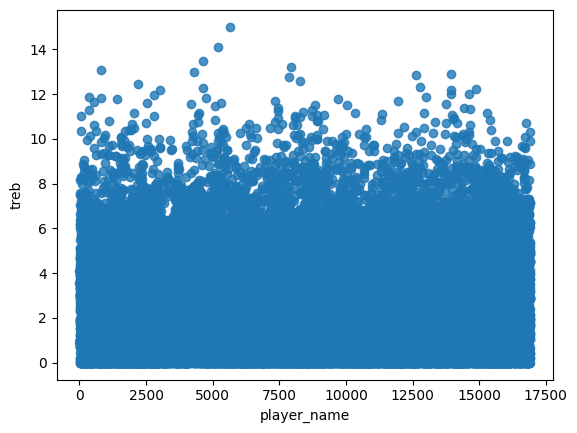

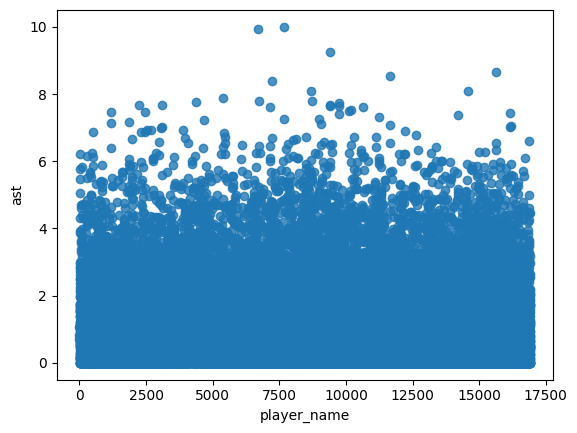

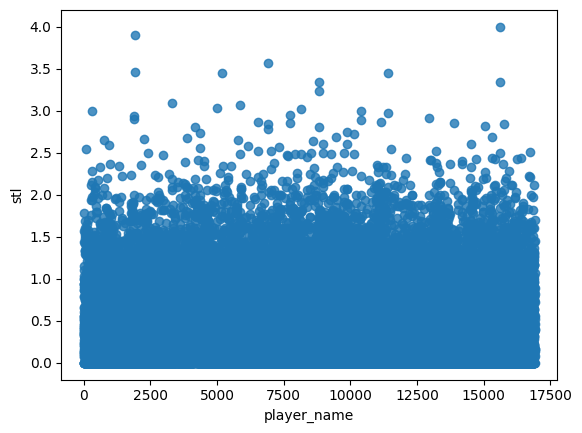

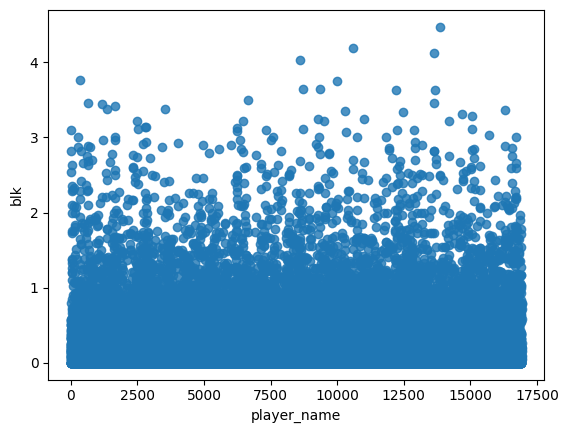

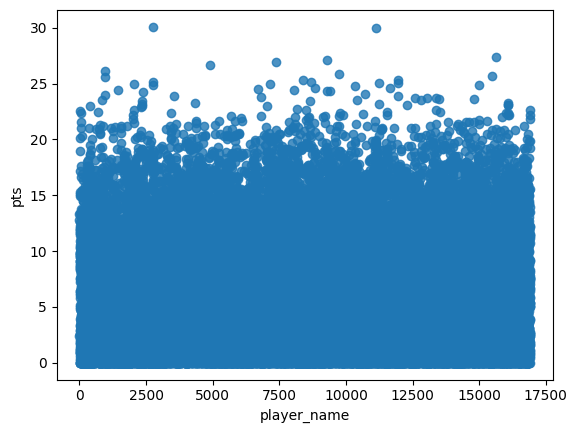

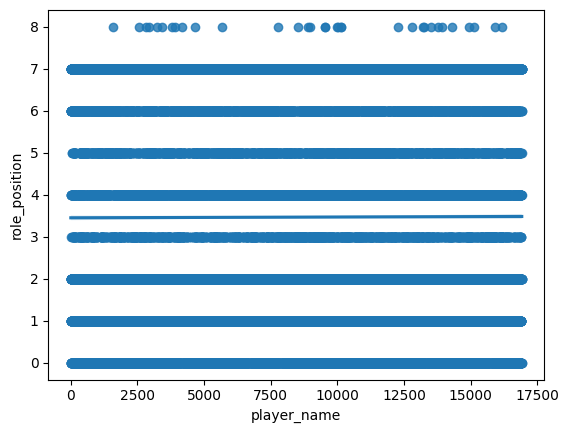

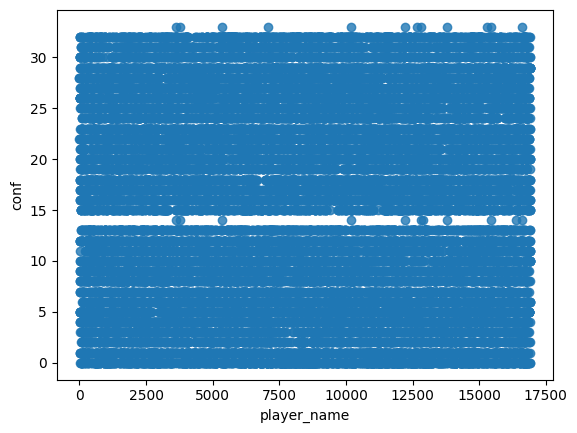

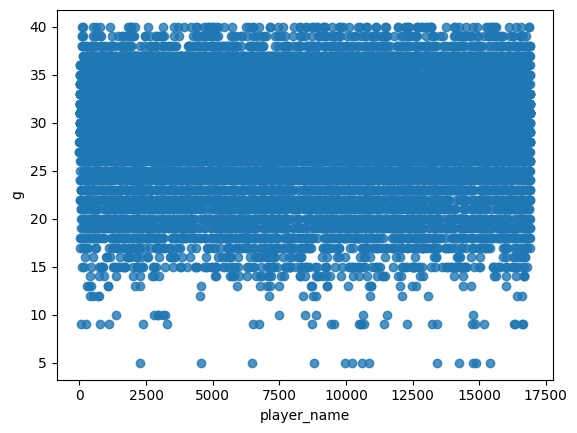

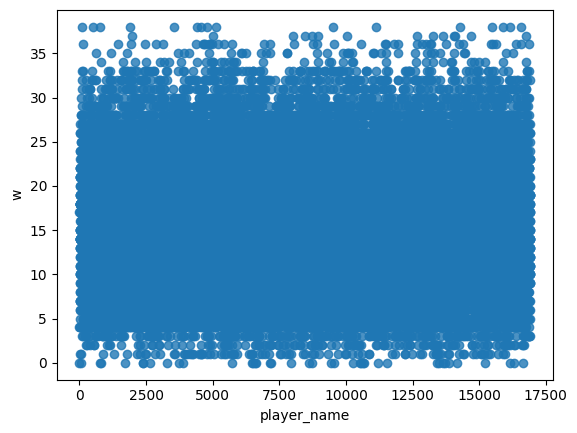

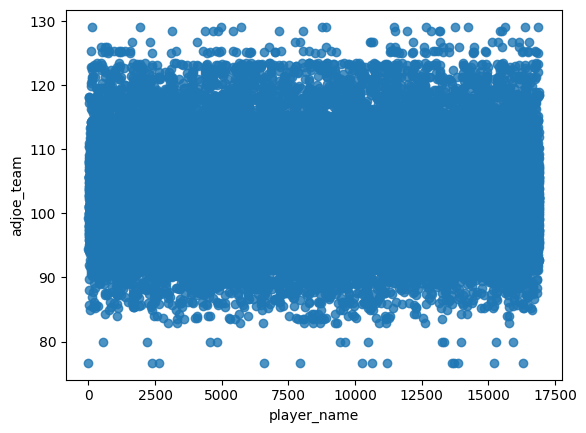

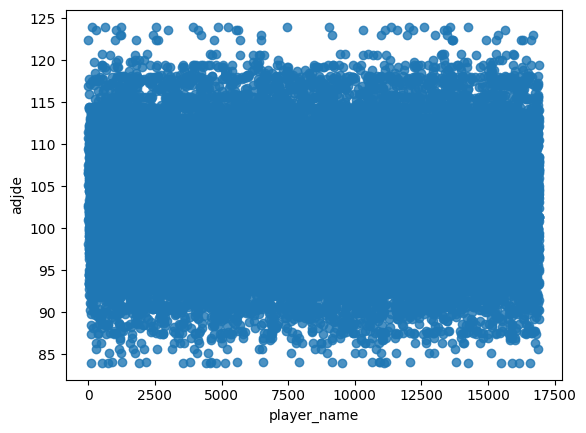

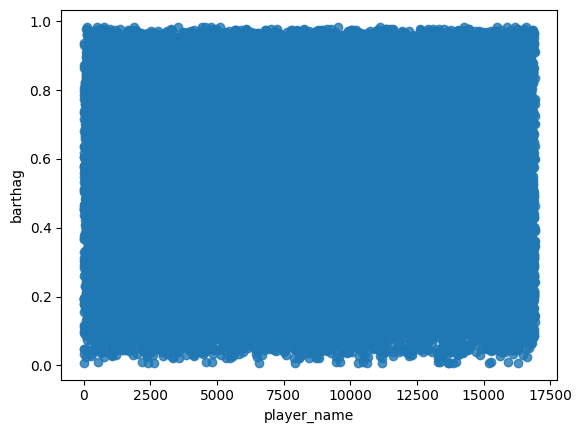

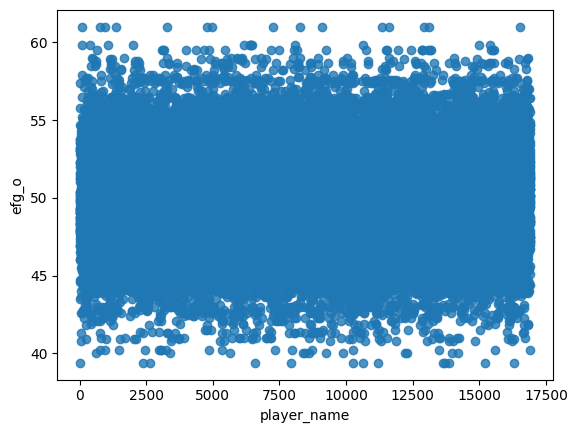

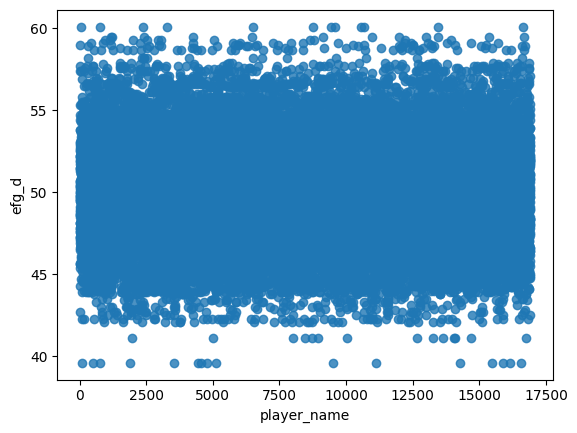

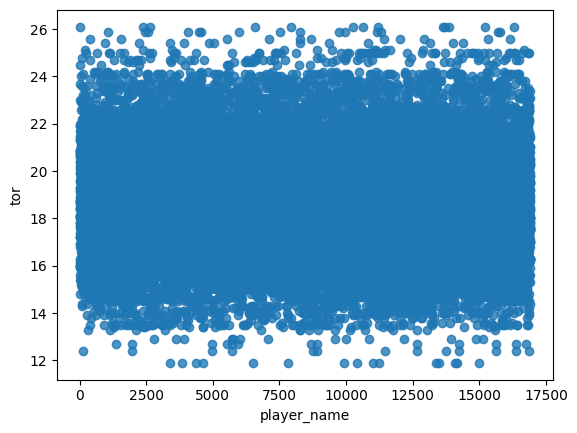

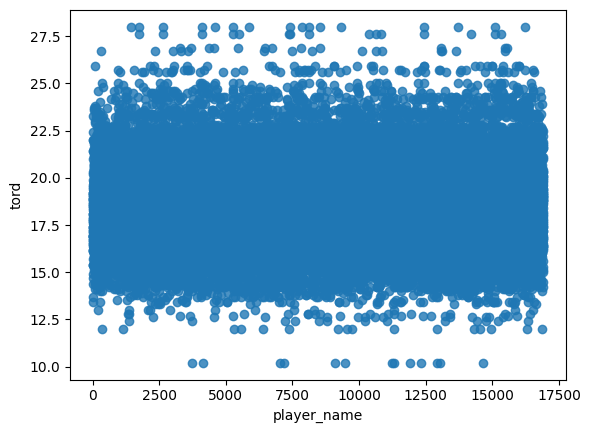

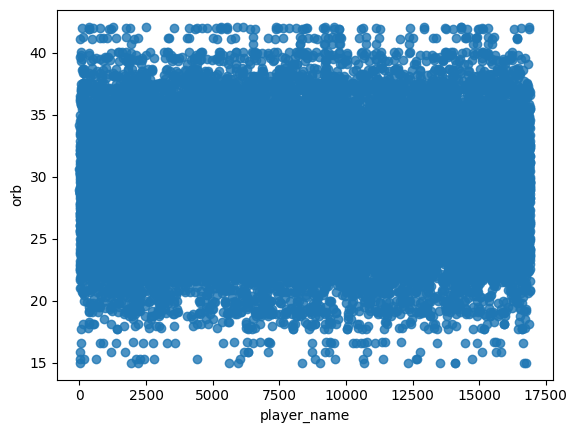

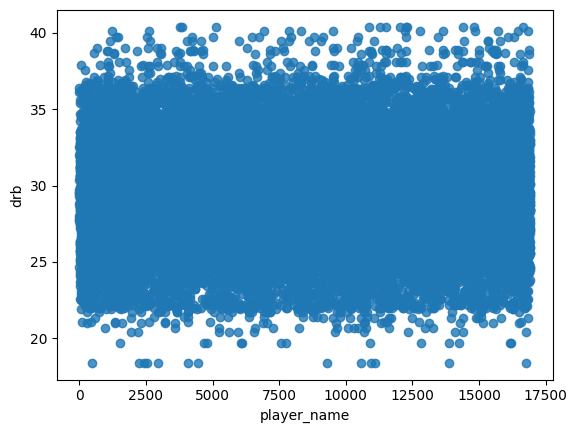

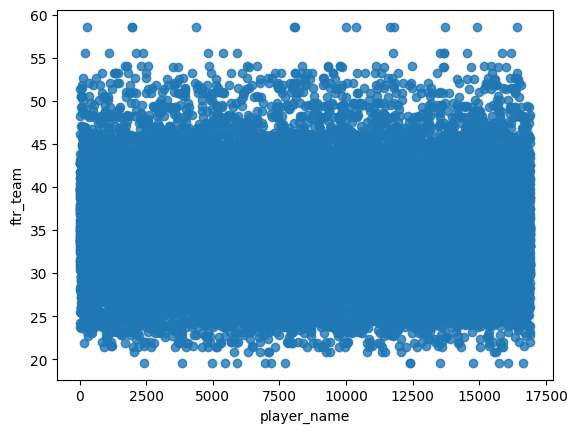

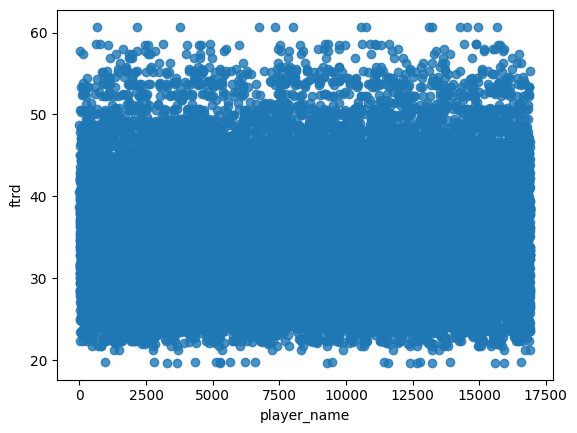

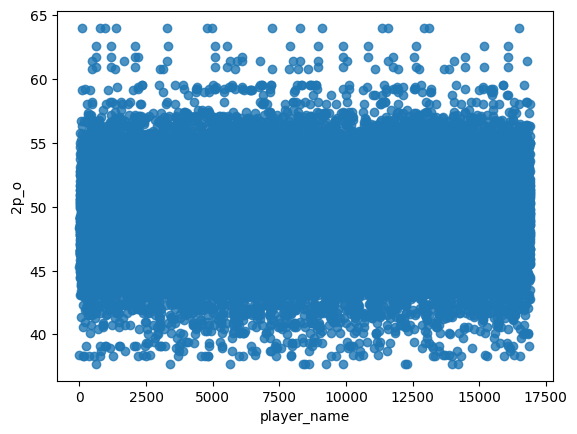

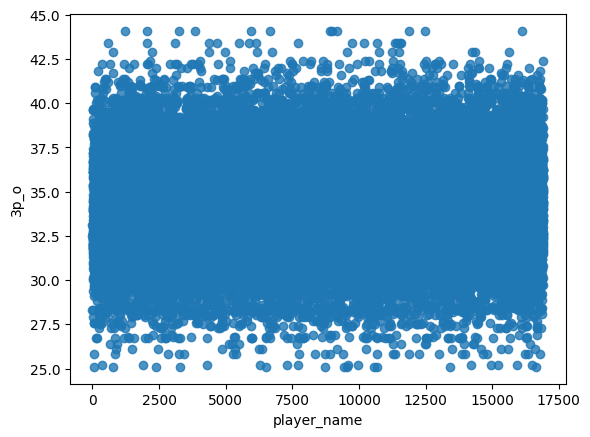

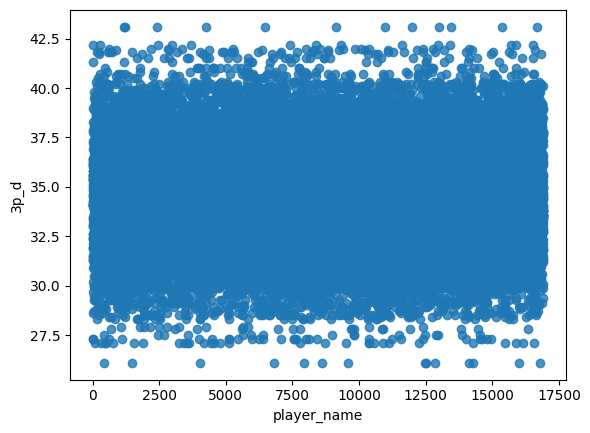

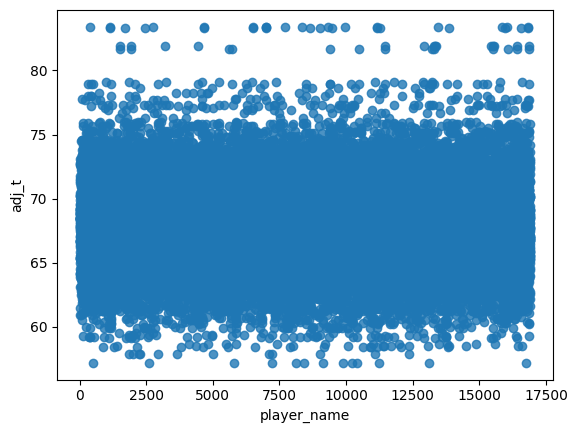

In [27]:
for j in range(1, len(trainDf.columns)):
    sns.regplot(x=trainDf.columns[0], y=trainDf.columns[j], data=trainDf)
    plt.show()

## might need to add more smoothing since the dfs are merged 

In [29]:
# binning by means
def bin_mean(data, bin_size):
    binned_data = []
    for i in range(0, len(data), bin_size):
        mean_value = np.mean(data[i:i+bin_size])
        size = bin_size if i + bin_size < len(data) else len(data) - i
        binned_data.extend([mean_value] * size)
    return np.array(binned_data)

#binning with medians
def bin_median(data, bin_size):
    binned_data = []
    for i in range(0, len(data), bin_size):
        median_value = np.median(data[i:i+bin_size])
        size = bin_size if i + bin_size < len(data) else len(data) - i
        binned_data.extend([median_value] * size)
    return np.array(binned_data)

data = trainDf

binned_df = data.copy()

#Sort df 
#sorted_df = binned_df.sort_values(by=['team'])

# List of columns to be smoothed
columns_to_smooth = ["usg","TS_per","ORB_per", "DRB_per","AST_per", "TO_per", "FTM", "FTA", "FT_per", "twoPM", "twoPA", "twoP_per", "TPM", "TPA", "TP_per", "blk_per", "stl_per", "ftr", "ast/tov", "rimmade", "rimmade+rimmiss", "midmade", "midmade+midmiss", "rimmade/(rimmade+rimmiss)", "midmade/(midmade+midmiss)", "dunksmade", "dunksmiss+dunksmade", "dunksmade/(dunksmade+dunksmiss)", "drtg", "adrtg", "dporpag", "stops", "bpm", "obpm", "dbpm", "gbpm", "mp", "ogbpm", "dgbpm", "oreb", "dreb", "treb", "ast", "stl", "blk", "pts"]

#Need to update number of bins 
#This uses Sturges’ Formula: 1+log2(n)
num_bins = 17; 

#smooth columns
for col in columns_to_smooth:
    if col in data.columns: 
	#Change to sorted_df for sorting 
	#Change to bin_mean if needed
        binned_df[col] = bin_median(binned_df[col].values, num_bins) 

print(binned_df)

       player_name   team    GP   usg  TS_per  ORB_per  DRB_per  AST_per  \
0            801.0  135.0  28.0  18.4   49.87      4.6     12.3      4.7   
1           2940.0  135.0   7.0  18.4   49.87      4.6     12.3      4.7   
2          13959.0  135.0  30.0  18.4   49.87      4.6     12.3      4.7   
3            699.0  135.0  14.0  18.4   49.87      4.6     12.3      4.7   
4           4712.0  135.0   5.0  18.4   49.87      4.6     12.3      4.7   
...            ...    ...   ...   ...     ...      ...      ...      ...   
33294      15283.0  180.0  21.0  18.2   46.57      4.0     12.1      8.6   
33295       4570.0  180.0  13.0  18.2   46.57      4.0     12.1      8.6   
33296      13278.0  180.0  19.0  18.2   46.57      4.0     12.1      8.6   
33297       9452.0  180.0  18.0  18.2   46.57      4.0     12.1      8.6   
33298      10486.0  180.0  15.0  18.2   46.57      4.0     12.1      8.6   

       TO_per   FTM  ...   tor  tord   orb   drb  ftr_team  ftrd  2p_o  3p_o  \
0      

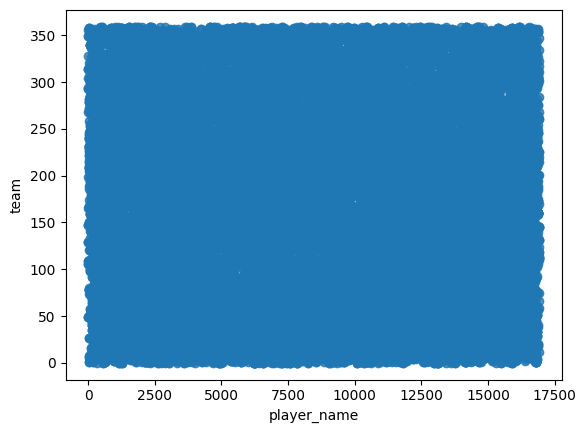

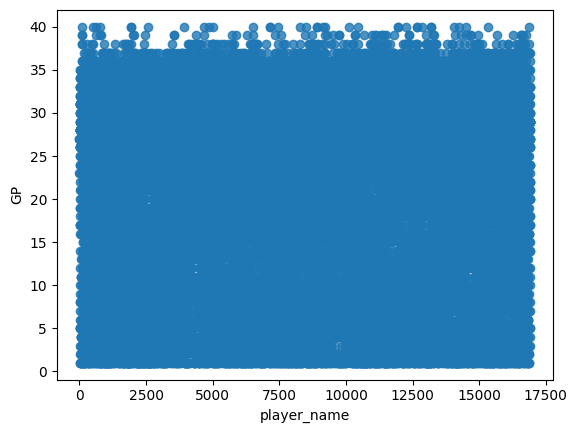

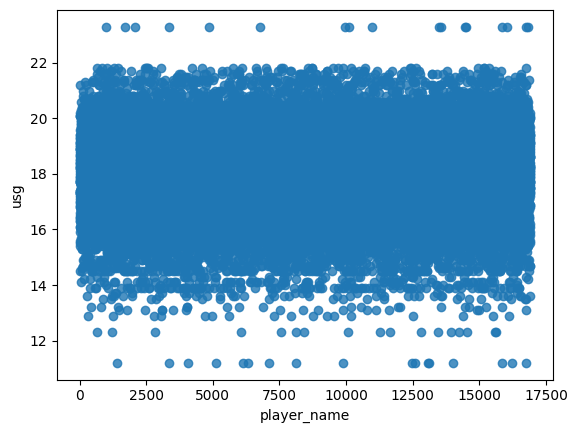

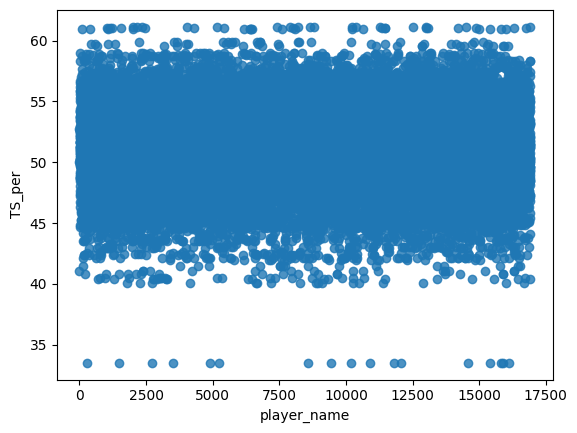

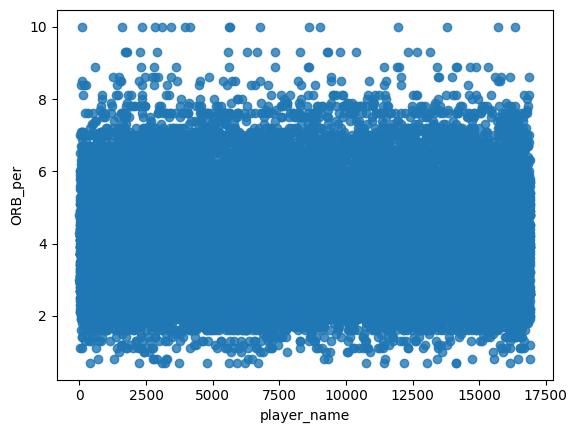

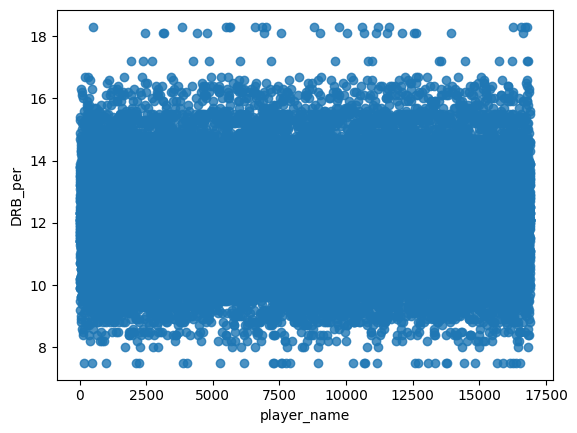

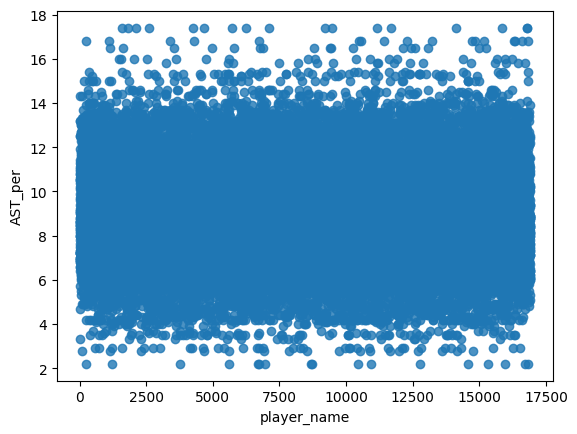

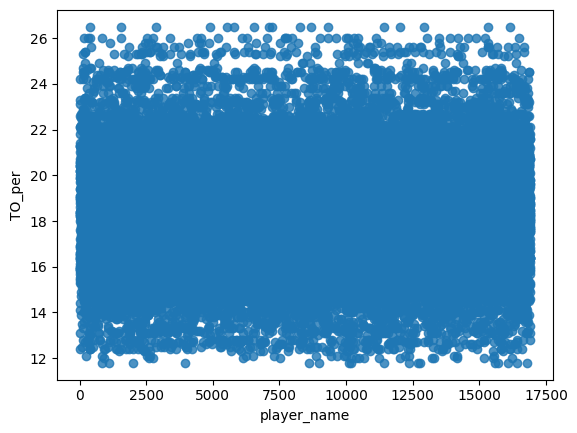

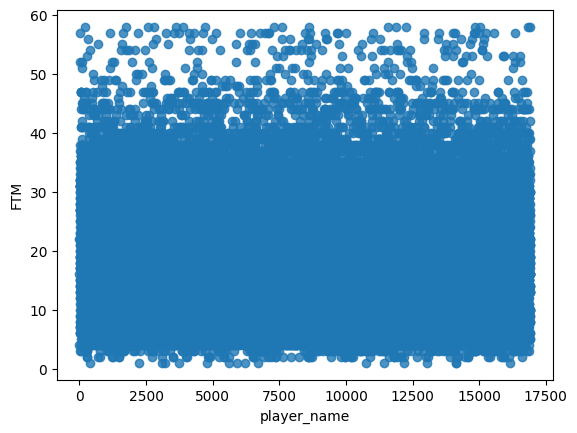

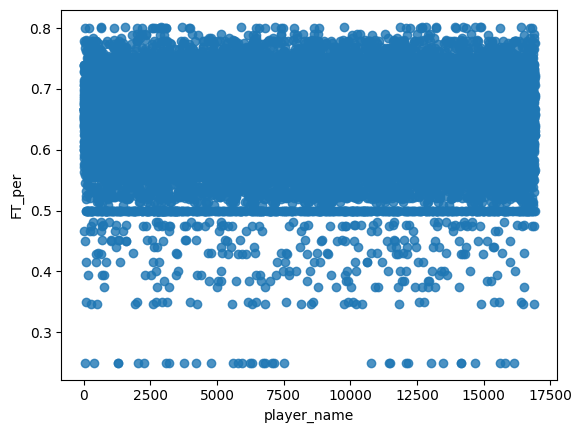

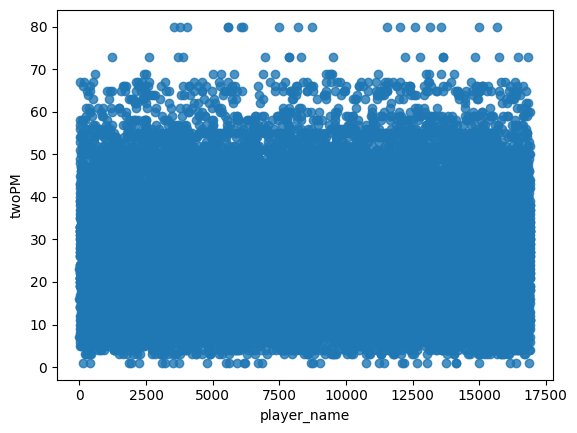

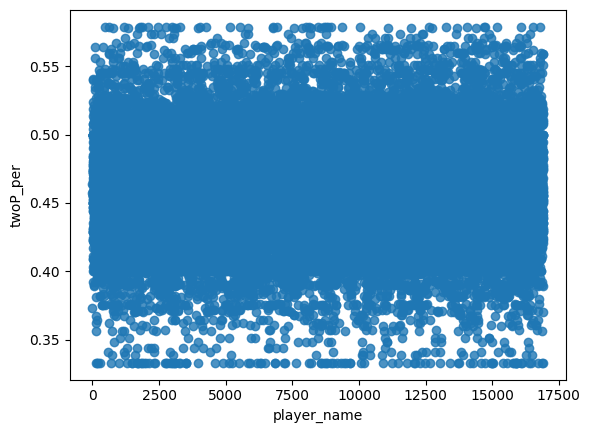

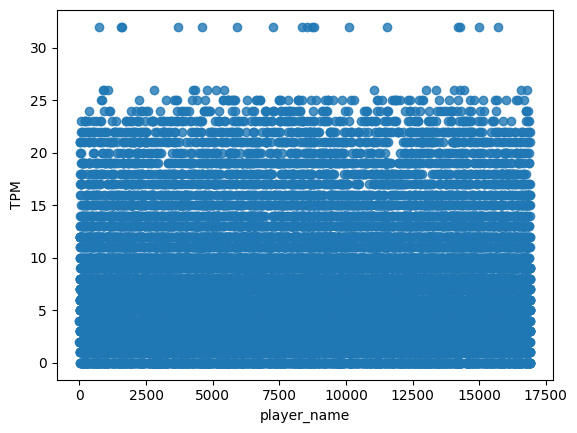

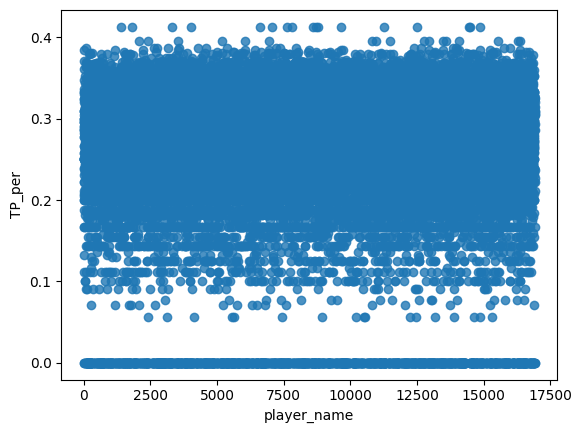

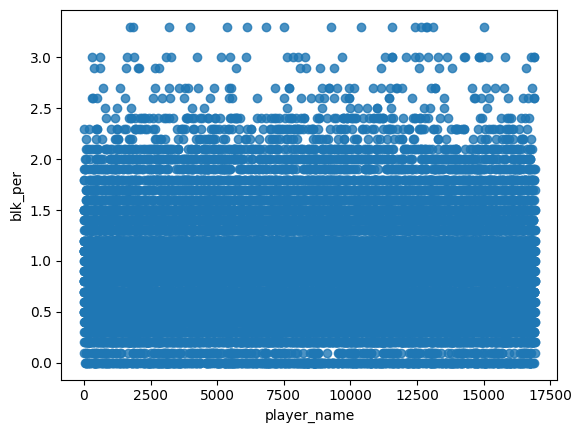

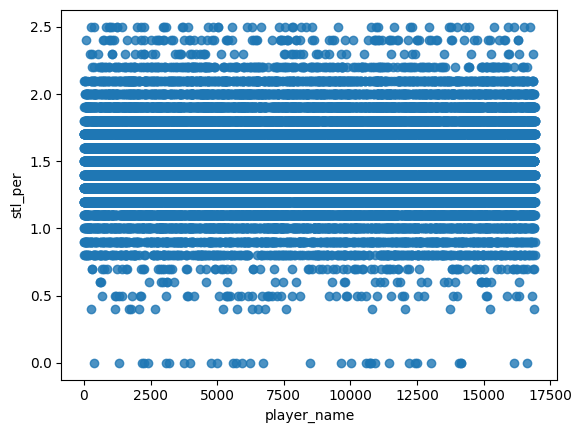

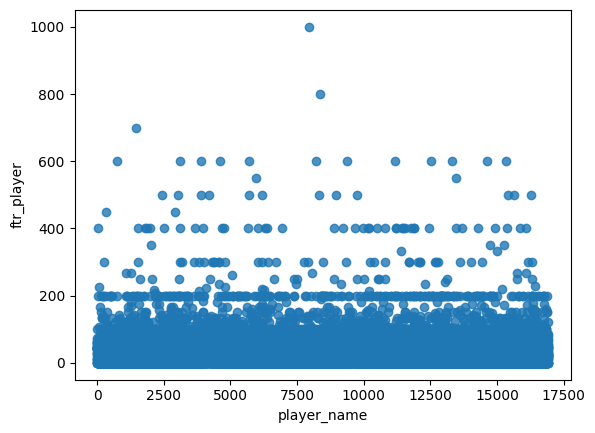

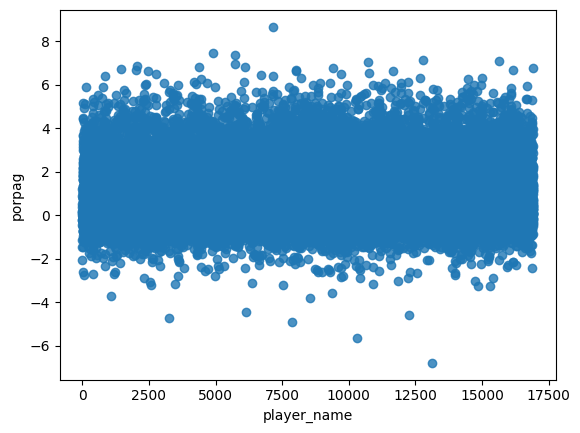

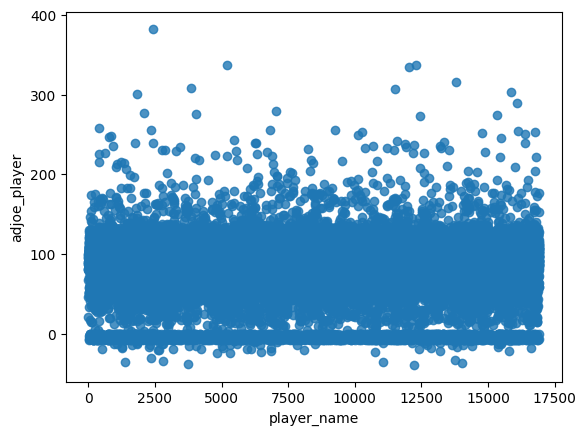

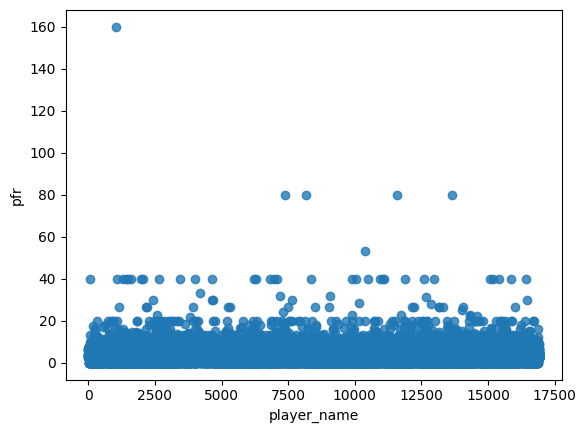

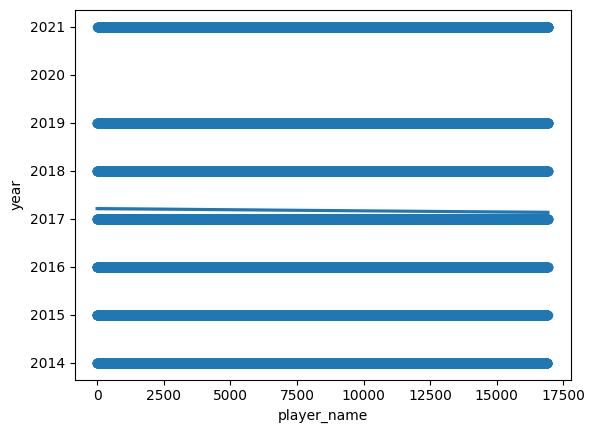

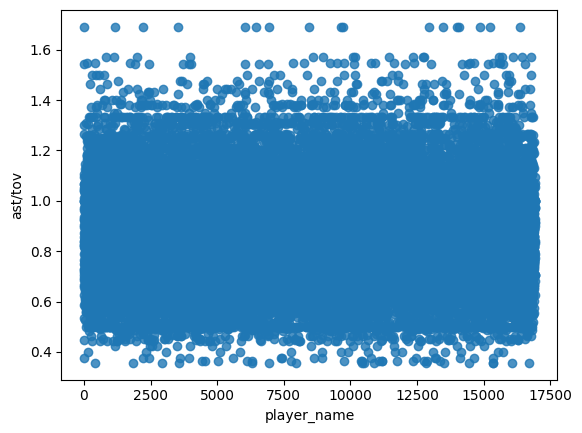

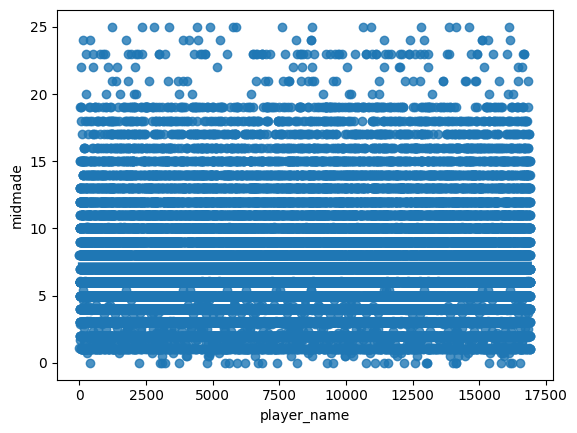

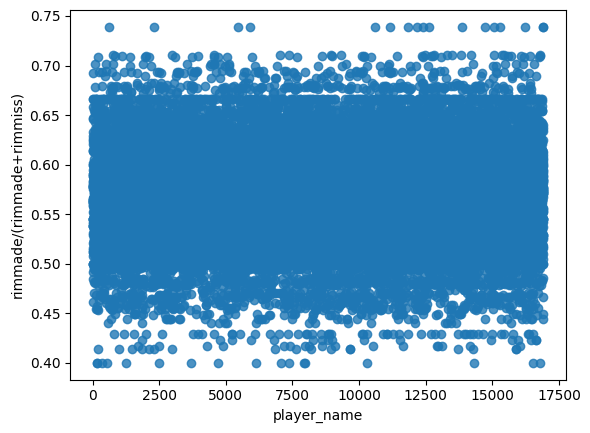

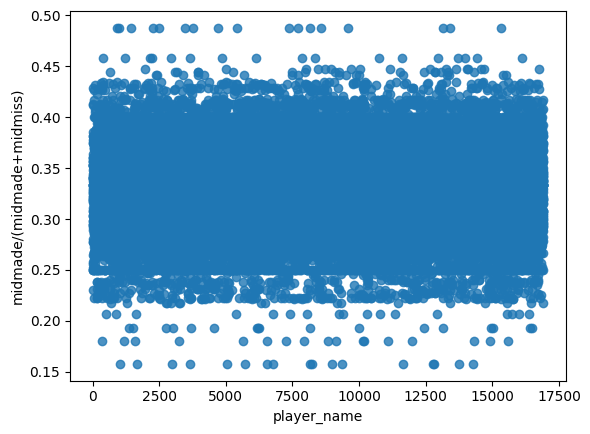

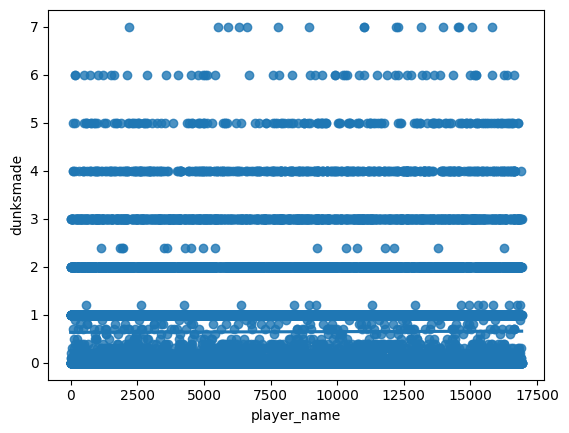

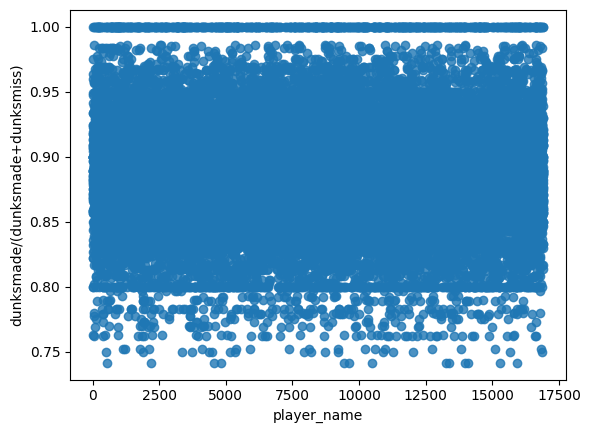

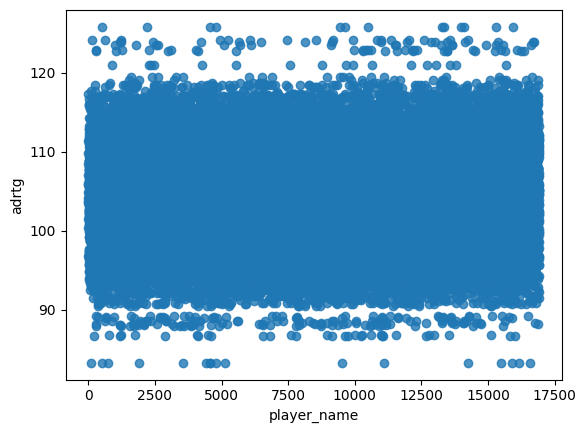

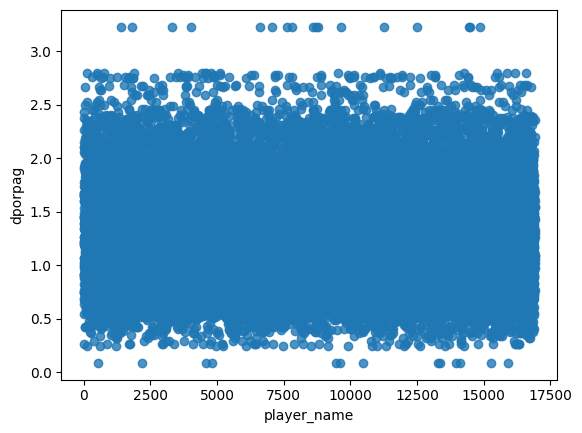

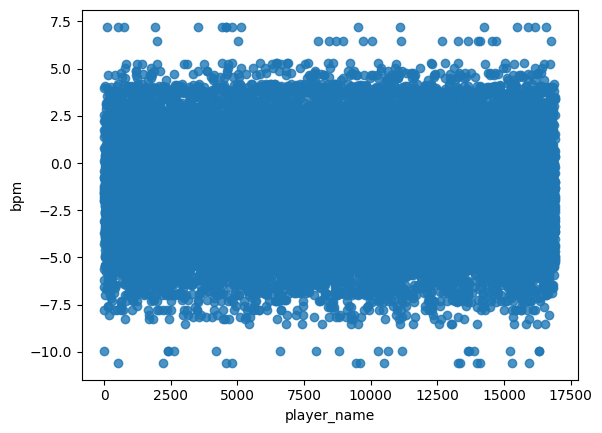

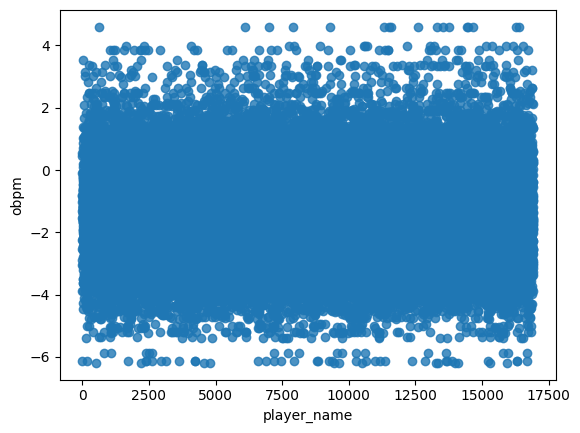

In [ ]:
for j in range(1, len(binned_df.columns)):
    sns.regplot(x=binned_df.columns[0], y=binned_df.columns[j], data=binned_df)
    plt.show()